Sentiment-wise Analysis:
  classification  total_trades  avg_closed_pnl  median_closed_pnl  \
0   Extreme Fear         21400       34.537862                0.0   
1  Extreme Greed         39992       67.892861                0.0   
2           Fear         61837       54.290400                0.0   
3          Greed         50303       42.743559                0.0   
4        Neutral         37686       34.307718                0.0   

   total_closed_pnl  avg_execution_price  avg_trade_size  
0      7.391102e+05          7054.795108     1675.893319  
1      2.715171e+06          6082.195865     8832.415746  
2      3.357155e+06         14152.620222     2992.641845  
3      2.150129e+06         13411.276344     4715.327756  
4      1.292921e+06         12393.692779     4383.368714  

Top 5 Traders During 'Extreme Greed':
                                        Account classification  total_trades  \
135  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  Extreme Greed          1643   
152  0x

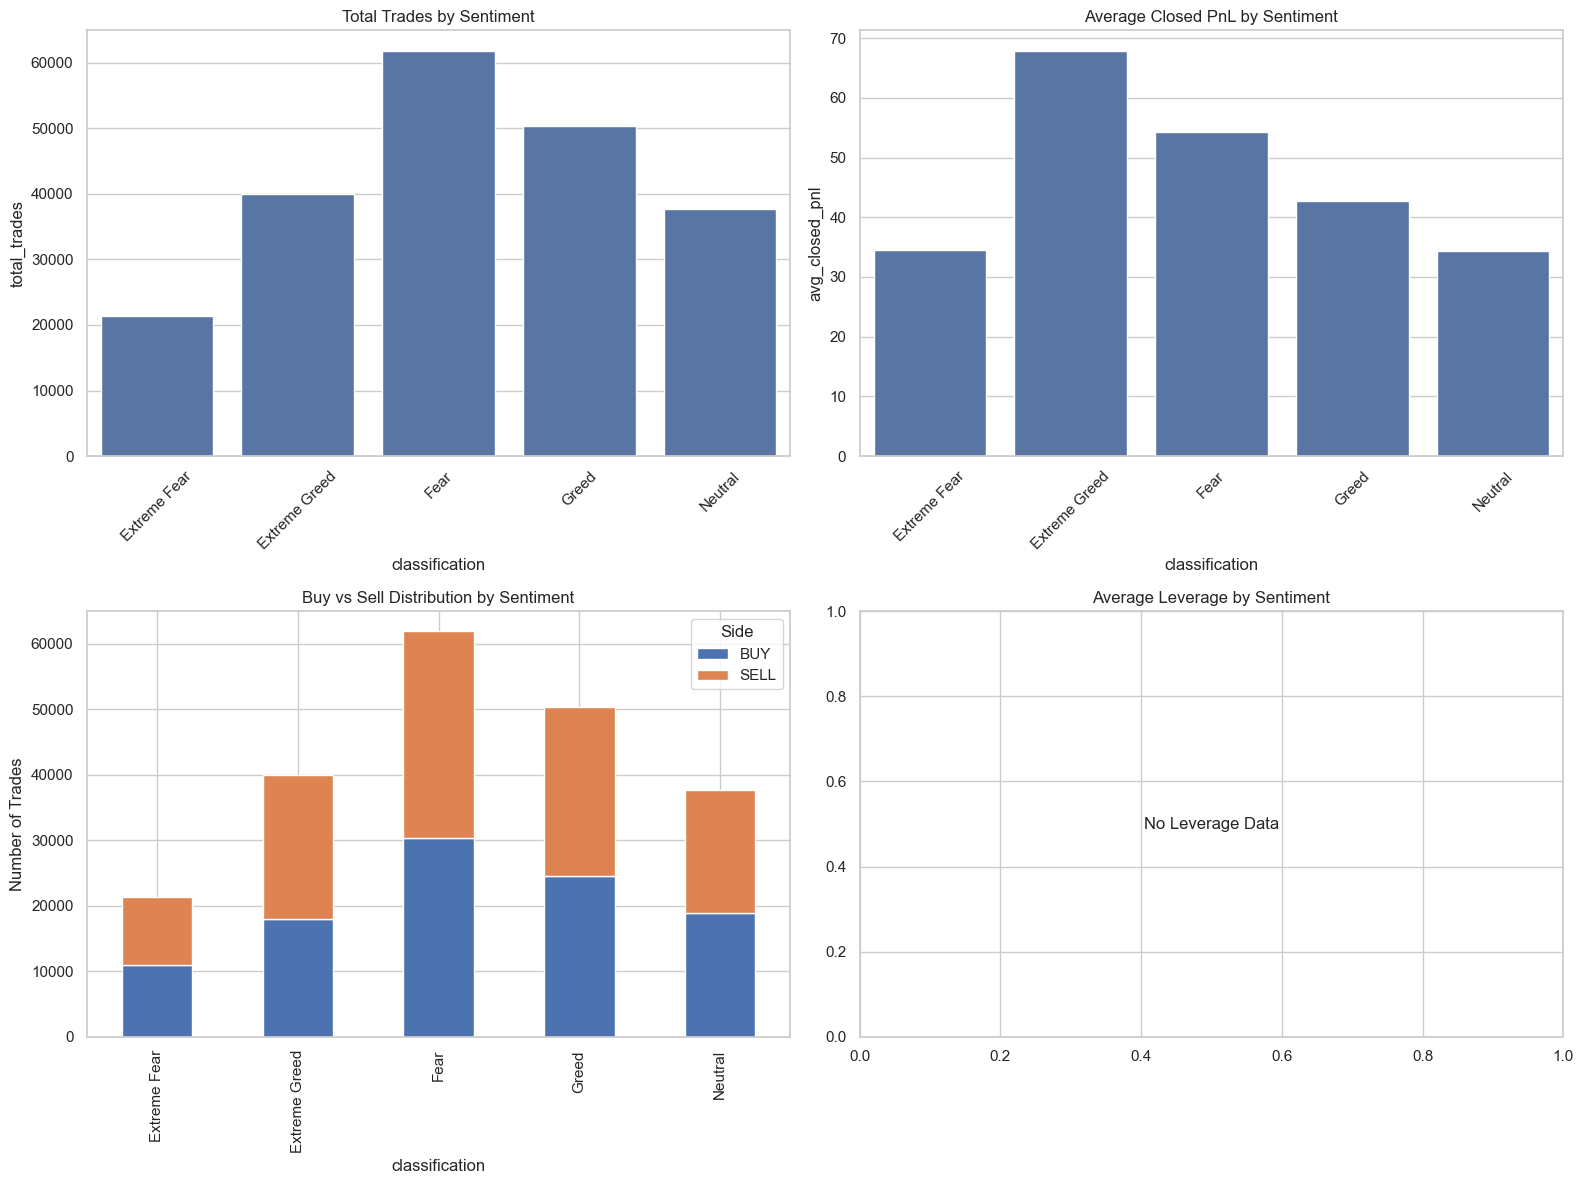

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
historical_df = pd.read_csv(r"C:\Users\Hp\Downloads\historical_data.csv")
fear_greed_df = pd.read_csv(r"C:\Users\Hp\Downloads\fear_greed_index.csv")

# ========== Data Preprocessing ==========

# Convert 'Timestamp IST' to datetime
historical_df["Date"] = pd.to_datetime(historical_df["Timestamp IST"], format="%d-%m-%Y %H:%M").dt.date

# Convert 'date' column in fear/greed to datetime
fear_greed_df["Date"] = pd.to_datetime(fear_greed_df["date"]).dt.date

# Merge both datasets on 'Date'
merged_df = pd.merge(historical_df, fear_greed_df[["Date", "classification"]], on="Date", how="left")

# Convert Size Tokens to numeric
merged_df["Size Tokens"] = pd.to_numeric(merged_df["Size Tokens"], errors="coerce")

# ========== Sentiment-wise Performance Analysis ==========
sentiment_analysis = merged_df.groupby("classification").agg(
    total_trades=("Account", "count"),
    avg_closed_pnl=("Closed PnL", "mean"),
    median_closed_pnl=("Closed PnL", "median"),
    total_closed_pnl=("Closed PnL", "sum"),
    avg_execution_price=("Execution Price", "mean"),
    avg_trade_size=("Size Tokens", "mean")
).reset_index()

print("Sentiment-wise Analysis:")
print(sentiment_analysis)

# ========== Individual Trader Performance ==========
trader_performance = (
    merged_df.groupby(["Account", "classification"])
    .agg(
        total_trades=("Closed PnL", "count"),
        total_pnl=("Closed PnL", "sum"),
        avg_pnl=("Closed PnL", "mean")
    )
    .reset_index()
)

# Top 5 traders under Extreme Greed
top_traders_extreme_greed = trader_performance[trader_performance["classification"] == "Extreme Greed"] \
                            .sort_values(by="total_pnl", ascending=False).head(5)

print("\nTop 5 Traders During 'Extreme Greed':")
print(top_traders_extreme_greed)

# ========== Behavior Pattern Analysis ==========
# Clean leverage if available
if "leverage" in merged_df.columns:
    merged_df["Leverage"] = pd.to_numeric(merged_df["leverage"], errors="coerce")
else:
    merged_df["Leverage"] = None

# Side (Buy/Sell) distribution by sentiment
side_distribution = merged_df.groupby(["classification", "Side"]).size().unstack(fill_value=0)

print("\nBuy vs Sell Distribution:")
print(side_distribution)

# Average leverage per sentiment
leverage_by_sentiment = merged_df.groupby("classification")["Leverage"].mean()

print("\nAverage Leverage by Sentiment:")
print(leverage_by_sentiment)

# ========== Visualization ==========
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Total trades per sentiment
sns.barplot(x="classification", y="total_trades", data=sentiment_analysis, ax=axs[0, 0])
axs[0, 0].set_title("Total Trades by Sentiment")
axs[0, 0].tick_params(axis='x', rotation=45)

# Average PnL per sentiment
sns.barplot(x="classification", y="avg_closed_pnl", data=sentiment_analysis, ax=axs[0, 1])
axs[0, 1].set_title("Average Closed PnL by Sentiment")
axs[0, 1].tick_params(axis='x', rotation=45)

# Side distribution plot
side_distribution.plot(kind="bar", stacked=True, ax=axs[1, 0])
axs[1, 0].set_title("Buy vs Sell Distribution by Sentiment")
axs[1, 0].set_ylabel("Number of Trades")

# Average leverage
if merged_df["Leverage"].notnull().any():
    leverage_by_sentiment.plot(kind="bar", ax=axs[1, 1])
    axs[1, 1].set_title("Average Leverage by Sentiment")
    axs[1, 1].set_ylabel("Leverage")
else:
    axs[1, 1].text(0.5, 0.5, 'No Leverage Data', horizontalalignment='center', verticalalignment='center')
    axs[1, 1].set_title("Average Leverage by Sentiment")

plt.tight_layout()
plt.show()
